In [46]:
import bisect
import itertools as it
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla
import random
import sys
%matplotlib inline

Define the transition probabilities

In [2]:
weights = np.array([0, 0.01, 0.0001])
weights[0] = 1 - weights.sum()
# weights now has the values [0.9899, 0.01, 0.0001] which are the probabilities

This is a class that randomly chooses one of a set of elements with specified weights.

In [3]:
# adapted from http://stackoverflow.com/a/4322940/56541
class random_chooser(object):
    '''Implements a weighted random choice, one where the probability
    distribution of the choices is not uniform. The probability of choosing
    a particular element is proportional to the weight associated with
    that element; weights are provided along with the elements, in the
    class constructor.'''
    def __init__(self, choices):
        '''Constructs an object to randomly choose from the given options.

        The argument can be a dict in which the keys are the choices and
        the values are the associated weights, or it can be a list-like
        object of length N, in which case the choices will be 0,1,...,N-1
        and the weights will be the elements of the list. In either case
        the weights must be numeric.'''
        if len(choices) == 1:
            if isinstance(choices, dict):
                self.choose = lambda: list(choices.values())[0]
            else:
                self.choose = lambda: 0
        if isinstance(choices, dict):
            weight_iter = choices.values()
            value_iter = choices.keys()
        else:
            weight_iter = iter(choices)
            value_iter = range(len(choices))
        self.cumulative_weights = list(it.accumulate(weight_iter))
        self.values = list(value_iter)
    def choose(self):
        '''Returns an element randomly chosen according to the probabilities
        provided in the constructor.'''
        x = random.random() * self.cumulative_weights[-1]
        i = bisect.bisect(self.cumulative_weights, x)
        return self.values[i]
    def __len__(self):
        return len(self.values)

def test_random_chooser():
    choices = random_chooser({0: 10, 1: 45, 2: 25, 3: 20})
    results = [0] * len(choices)
    for n in range(100000):
        results[choices.choose()] += 1
    print(results)

The test should return something close to `[10000, 45000, 25000, 20000]`.

In [4]:
test_random_chooser()

[10004, 45247, 24969, 19780]


# Monte Carlo

The Monte Carlo simulation starts with a state representing the frequency of a photon. Instead of a vector as in Chad's code, my implementation represents the frequency by an integer. For the three-frequency simple case, 0 is the main frequency, 1 is the medium frequency, and 2 is the low frequency.

At each step, the code makes the following choices:

1. A photon in state $\lvert i\rangle$ can be absorbed with probability $P_i$, or not absorbed with probability $1 - P_i$.
2. If it was absorbed, it will be reemitted into state $\lvert j\rangle$ with probability $P_{ji}$.

In [10]:
def monte_carlo(state, absorb_weights, emit_weights):
    '''Create a generator to run the Monte Carlo simulation.
    
    absorb_weights is an iterable of the probabilities P_i
    emit_weights is a matrix (an iterable of lists) of the
    probabilities P_ji, such that emit_weights[i][j] = P_ji'''
    absorb_chooser = [random_chooser({True: w, False: 1-w}) for w in absorb_weights]
    emit_chooser = [random_chooser(w) for w in emit_weights]
    while True:
        if absorb_chooser[state].choose():
            state = emit_chooser[state].choose()
        yield state

In [22]:
def compute_with_monte_carlo(initial_freq, steps, absorb_weights, emit_weights, iterations=10000):
    total = np.zeros(3)
    for n in range(iterations):
        for s in it.islice(monte_carlo(initial_freq, absorb_weights, emit_weights), steps):
            pass
        total[s] += 1
    return total/total.sum()

# Transition matrix 

The transition matrix method calculates the transition probabilities instead of simulating individual absorptions and emissions. In this case, the state is a NumPy array in which element `i` is the probability of a photon having frequency `f_i`. For the three-frequency simple case, a photon at the main frequency is represented by the state vector `[1,0,0]`, a photon at the medium frequency is represented by `[0,1,0]`, and one at the low frequency by `[0,0,1]`.

Each absorption/emission step is represented by the application of a transition matrix, which is computed as
$$\begin{equation}
T = \underbrace{\begin{pmatrix}
P_{00} & P_{01} & \cdots \\
P_{10} & P_{11} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}}_\text{emit}
\underbrace{\begin{pmatrix}
P_0 & 0 & \cdots \\
0 & P_1 & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}}_\text{absorb}
+
\underbrace{\left[I - \begin{pmatrix}
P_0 & 0 & \cdots \\
0 & P_1 & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}\right]}_\text{not absorbed}
\end{equation}$$

In [12]:
def transition_matrix(absorb_weights, emit_weights):
    '''Create the transition matrix that represents one step.
    
    absorb_weights is an iterable of the probabilities P_i
    emit_weights is a matrix of the probabilities P_ji,
    such that emit_weights[i][j] = P_ji'''
    emit_matrix = emit_weights.T
    absorb_matrix = np.diag(absorb_weights)
    identity = np.identity(len(absorb_weights))
    return emit_matrix.dot(absorb_matrix) + (identity - absorb_matrix)

In [23]:
def compute_with_transition_matrix(initial_freq, steps, absorb_weights, emit_weights):
    initial_state = np.zeros(len(absorb_weights))
    initial_state[initial_freq] = 1
    full_transition_matrix = npla.matrix_power(transition_matrix(absorb_weights, emit_weights), steps)
    return full_transition_matrix.dot(np.array([1,0,0]))

#Test data 

This reproduces the first plot in the blog post

In [54]:
weights = np.array([0, 0.01, 0.0001])
weights[0] = 1 - weights.sum()
# weights now has the values [0.9899, 0.01, 0.0001] which are the probabilities

absorb_weights = np.array([
 # probability of absorbing a photon in state 0
 1,
 # probability of absorbing a photon in state 1
 weights[1],
 # probability of absorbing a photon in state 2
 weights[2]
])
emit_weights = np.array([
 # probabilities of emitting a photon from state 0 back to...
 weights[[
  0, # state 0 (P_00)
  1, # state 1 (P_10)
  2  # state 2 (P_20)
 ]],
 # probabilities of emitting a photon from state 1 back to...
 weights[[
  1, # state 0 (P_01)
  0, # state 1 (P_11)
  2  # state 2 (P_21)
 ]],
 # probabilities of emitting a photon from state 2 back to...
 weights[[
  2, # state 0 (P_02)
  1, # state 1 (P_12)
  0  # state 2 (P_22)
 ]]
])

In [55]:
print(compute_with_monte_carlo(0, 100, absorb_weights, emit_weights))
print(compute_with_transition_matrix(0, 100, absorb_weights, emit_weights))

[ 0.3658  0.6271  0.0071]
[ 0.36497205  0.62866848  0.00635947]


In [56]:
counts = [int(pow(10,n/3.)) for n in range(30)]
results = np.array([compute_with_transition_matrix(0, n, absorb_weights, emit_weights) for n in counts])

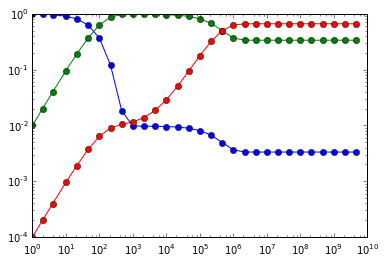

In [57]:
plt.loglog(counts, results, 'o-')

And the second plot

In [58]:
absorb_weights = np.array([
 # probability of absorbing a photon in state 0
 1,
 # probability of absorbing a photon in state 1
 weights[1],
 # probability of absorbing a photon in state 2
 weights[2]
])
emit_weights = np.array([
 # probabilities of emitting a photon from state 0 back to...
 weights[[
  0, # state 0 (P_00)
  1, # state 1 (P_10)
  2  # state 2 (P_20)
 ]],
 # probabilities of emitting a photon from state 1 back to...
 weights[[
  0, # state 0 (P_01)
  1, # state 1 (P_11)
  2  # state 2 (P_21)
 ]],
 # probabilities of emitting a photon from state 2 back to...
 weights[[
  0, # state 0 (P_02)
  1, # state 1 (P_12)
  2  # state 2 (P_22)
 ]]
])

In [59]:
counts = [int(pow(10,n/3.)) for n in range(30)]
results = np.array([compute_with_transition_matrix(0, n, absorb_weights, emit_weights) for n in counts])

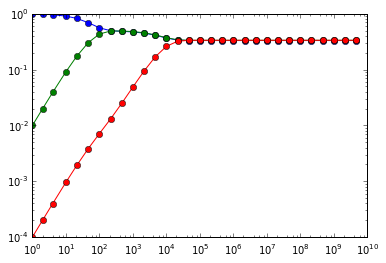

In [60]:
plt.loglog(counts, results, 'o-')